In [4]:
from bs4 import BeautifulSoup
import random
# Requests
import requests
from tqdm import tqdm
import pandas as pd
import numpy as np
import sys
import psycopg2
from psycopg2 import OperationalError, errorcodes, errors
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

In [5]:
df_categoria = pd.read_csv('../datos/categorias.csv')
df_mergeo_1 = pd.read_csv('../datos/precios_mergeo.csv')
df_supermercado = pd.read_csv('../datos/supermercados.csv')

Conexión a DDBB

In [6]:
try:
    conexion = psycopg2.connect(
    database = 'Supermercados',
    user = 'postgres',
    password = 'admin',
    host = 'localhost',
    port = '5432')
except OperationalError as e: #el alias es e
    if e.pgcode == errorcodes.INVALID_PASSWORD:
        print('la contraseña es erronea')
    elif e.pgcode == errorcodes.CONNECTION_EXCEPTION:
        print('error de conexion')
    else:
        print(f'el error es el siguiente {e}')

Creación de la tabla de supermercados.

In [5]:
cursor = conexion.cursor() #para crear la tabla desde aquí
query_creacion_supermercados = """ 
    CREATE TABLE IF NOT EXISTS Supermercado (
    Id_Supermercado int PRIMARY KEY,
    Supermercado varchar(100));

"""

cursor.execute(query_creacion_supermercados)
conexion.commit()

In [6]:
lista_tuplas2 = []
for fila in df_supermercado.values:
    lista_tuplas2.append(tuple(fila))

In [7]:
lista_tuplas2

[(1, 'mercadona'),
 (2, 'carrefour'),
 (3, 'eroski'),
 (4, 'dia'),
 (5, 'hipercor'),
 (6, 'alcampo')]

In [8]:
query_creacion_supermercados = 'INSERT INTO Supermercado (Id_Supermercado, Supermercado) VALUES (%s, %s)' # insertar valores %s es como un formato. como un argumento
for valores in lista_tuplas2:
    cursor.execute(query_creacion_supermercados, valores)
conexion.commit()

UniqueViolation: llave duplicada viola restricción de unicidad «supermercado_pkey»
DETAIL:  Ya existe la llave (id_supermercado)=(1).


Creación de la tabla Categorías

In [76]:
cursor = conexion.cursor() 
query_creacion_categorias = """ 
    CREATE TABLE IF NOT EXISTS Categoria (
    Id_Categoria int PRIMARY KEY,
    Categoria varchar(100));

"""
cursor.execute(query_creacion_categorias)
conexion.commit()


In [77]:
lista_tuplas3 = []
for fila in df_categoria.values:
    lista_tuplas3.append(tuple(fila))

In [78]:
lista_tuplas3

[(1, 'aceite-de-girasol'), (2, 'aceite-de-oliva'), (3, 'leche')]

In [79]:
query_creacion_categorias = 'INSERT INTO Categoria (Id_Categoria, Categoria) VALUES (%s, %s)' # insertar valores %s es como un formato. como un argumento
for valores in lista_tuplas3:
    cursor.execute(query_creacion_categorias, valores)
conexion.commit()

In [80]:
cursor = conexion.cursor() 
query_creacion_tabla_historica = """ 
    CREATE TABLE IF NOT EXISTS datos_historicos (
    Fecha DATE,
    Precio FLOAT NOT NULL,
    Variación FLOAT,
    Artículo VARCHAR(300),
    Id_Categoria INT,
    Id_Supermercado INT,
    CONSTRAINT fk_Categoría FOREIGN KEY (Id_Categoria)
        REFERENCES Categoria(Id_Categoria),
    CONSTRAINT fk_Supermercado FOREIGN KEY (Id_Supermercado)
        REFERENCES Supermercado(Id_Supermercado)
);
"""

cursor.execute(query_creacion_tabla_historica)
conexion.commit()


In [81]:
lista_tuplas1 = []
for fila in df_mergeo_1.values:
    lista_tuplas1.append(tuple(fila))

In [82]:
query_creacion_tabla_historica = 'INSERT INTO datos_historicos (Fecha, Precio, Variación, Artículo, Id_Categoria, Id_Supermercado) VALUES (%s, %s, %s, %s, %s,%s)' # insertar valores %s es como un formato. como un argumento
for valores in lista_tuplas1:
    cursor.execute(query_creacion_tabla_historica, valores)
conexion.commit()

Queries

Comparar precios entre supermercados: determinar qué supermercados ofrecen los precios más bajos y cuáles son más caros para cada producto.

In [7]:
cursor = conexion.cursor() 
query_comparar_precio_super = """ 
# SELECT min(precio) AS precio_minimo, max(precio) AS precio_maximo, s.supermercado , c.categoria 
# FROM datos_historicos dh 
# inner JOIN supermercado s 
# ON dh.id_supermercado = s.id_supermercado 
# INNER JOIN categoria c 
# ON dh.id_categoria = c.id_categoria 
# GROUP BY c.categoria, s.supermercado 
# ORDER BY c.categoria, s.supermercado ;
# """
cursor.execute(query_comparar_precio_super)
df_comparar = pd.DataFrame(cursor.fetchall())
# # cursor.close()
# # conexion.close()# 

In [8]:
df_comparar.head()

,0,1,2,3
0,1.00,15.88,alcampo,aceite-de-girasol
1,1.45,40.67,carrefour,aceite-de-girasol
2,1.49,10.99,dia,aceite-de-girasol
3,1.39,11.99,eroski,aceite-de-girasol
4,1.40,12.79,hipercor,aceite-de-girasol


Evolucion de los precios a lo largo del tiempo

In [9]:
cursor=conexion.cursor()
query_evolucion_precios="""
SELECT dh.fecha, s.supermercado , c.categoria , sum(dh.variación) 
OVER (PARTITION BY s.supermercado, c.categoria ORDER BY dh.fecha) AS Variacion_acumulada
FROM datos_historicos dh 
INNER JOIN supermercado s ON dh.id_supermercado = s.id_supermercado 
INNER JOIN categoria c ON dh.id_categoria = c.id_categoria 
ORDER BY c.categoria, s.supermercado, dh.fecha;
"""
cursor.execute(query_evolucion_precios)
df_variacion_acumulada_precio = pd.DataFrame(cursor.fetchall())
# cursor.close()
# conexion.close()

In [29]:
df_variacion_acumulada_precio[0] = pd.to_datetime(df_variacion_acumulada_precio[0])


In [43]:
cursor=conexion.cursor()
query_evolucion_precios_g="""
SELECT dh.fecha, s.supermercado , c.categoria , sum(dh.variación) 
OVER (PARTITION BY s.supermercado, c.categoria ORDER BY dh.fecha) AS Variacion_acumulada
FROM datos_historicos dh 
INNER JOIN supermercado s ON dh.id_supermercado = s.id_supermercado 
INNER JOIN categoria c ON dh.id_categoria = c.id_categoria 
WHERE c.categoria = 'aceite-de-girasol'
ORDER BY c.categoria, s.supermercado, dh.fecha;
"""
cursor.execute(query_evolucion_precios_g)
df_variacion_acumulada_precio_g = pd.DataFrame(cursor.fetchall())
# cursor.close()
# conexion.close()



In [44]:
df_variacion_acumulada_precio_g[0] = pd.to_datetime(df_variacion_acumulada_precio_g[0])

In [45]:
df_variacion_acumulada_precio.head()

,0,1,2,3
0,2024-06-22,alcampo,aceite-de-girasol,0.0
1,2024-06-23,alcampo,aceite-de-girasol,0.0
2,2024-06-24,alcampo,aceite-de-girasol,0.0
3,2024-06-25,alcampo,aceite-de-girasol,0.0
4,2024-06-25,alcampo,aceite-de-girasol,0.0


<Axes: xlabel='0', ylabel='3'>

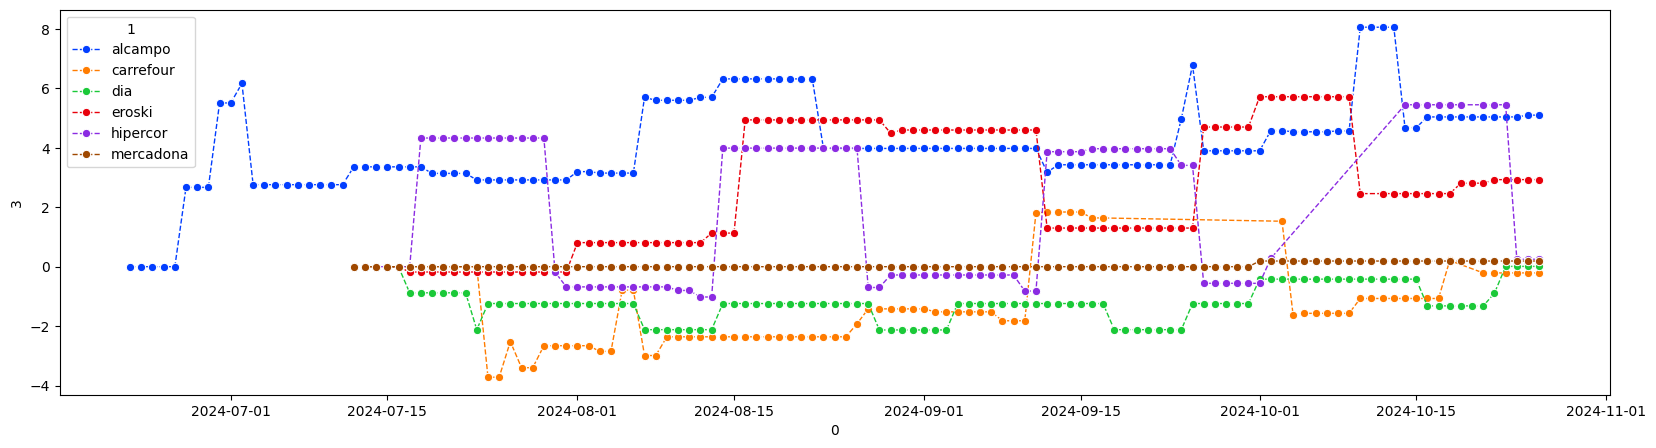

In [60]:
plt.figure(figsize=(20,5))
sns.lineplot(x = df_variacion_acumulada_precio_g[0],
              y = df_variacion_acumulada_precio_g[3], 
              hue = df_variacion_acumulada_precio_g[1], 
               marker = "o", 
                linewidth = 1, 
                palette="bright", 
                linestyle = "dashed", 
                errorbar = None)

Anomalías de precios por tiempo

In [10]:
cursor=conexion.cursor()
query_precios_anomalias="""
SELECT fecha, s.supermercado , c.categoria , sum(dh.variación) AS variacion_precio
FROM datos_historicos dh 
INNER JOIN supermercado s ON dh.id_supermercado = s.id_supermercado 
INNER JOIN categoria c ON dh.id_categoria = c.id_categoria 
GROUP BY c.categoria , s.supermercado , dh.fecha;
"""
cursor.execute(query_precios_anomalias)
df_anomalias_precios= pd.DataFrame(cursor.fetchall())

In [14]:
df_anomalias_precios.head()

,0,1,2,3
0,2024-06-22,alcampo,aceite-de-girasol,0.0
1,2024-06-23,alcampo,aceite-de-girasol,0.0
2,2024-06-24,alcampo,aceite-de-girasol,0.0
3,2024-06-25,alcampo,aceite-de-girasol,0.0
4,2024-06-26,alcampo,aceite-de-girasol,0.0


In [52]:


cursor=conexion.cursor()
query_anomalias_prueba="""
SELECT fecha, s.supermercado , c.categoria , sum(dh.variación) AS variacion_precio
FROM datos_historicos dh 
INNER JOIN supermercado s ON dh.id_supermercado = s.id_supermercado 
INNER JOIN categoria c ON dh.id_categoria = c.id_categoria 
WHERE c.categoria = 'aceite-de-girasol'
GROUP BY c.categoria , s.supermercado , dh.fecha;
"""
cursor.execute(query_precios_anomalias)
dfanomalias_prueba= pd.DataFrame(cursor.fetchall())

In [53]:
dfanomalias_prueba[0] = pd.to_datetime(dfanomalias_prueba[0])

In [55]:
dfanomalias_prueba.head()

,0,1,2,3
0,2024-06-22,alcampo,aceite-de-girasol,0.0
1,2024-06-23,alcampo,aceite-de-girasol,0.0
2,2024-06-24,alcampo,aceite-de-girasol,0.0
3,2024-06-25,alcampo,aceite-de-girasol,0.0
4,2024-06-26,alcampo,aceite-de-girasol,0.0


In [62]:
dfanomalias_prueba.describe()

,0,3
count,1947,1947.000000
mean,2024-08-29 16:27:21.910631680,-0.241582
min,2024-06-22 00:00:00,-88.580000
25%,2024-08-02 00:00:00,0.000000
50%,2024-08-29 00:00:00,0.000000
75%,2024-09-27 00:00:00,0.000000
max,2024-10-26 00:00:00,82.350000
std,NaN,6.898905


<Axes: xlabel='0', ylabel='3'>

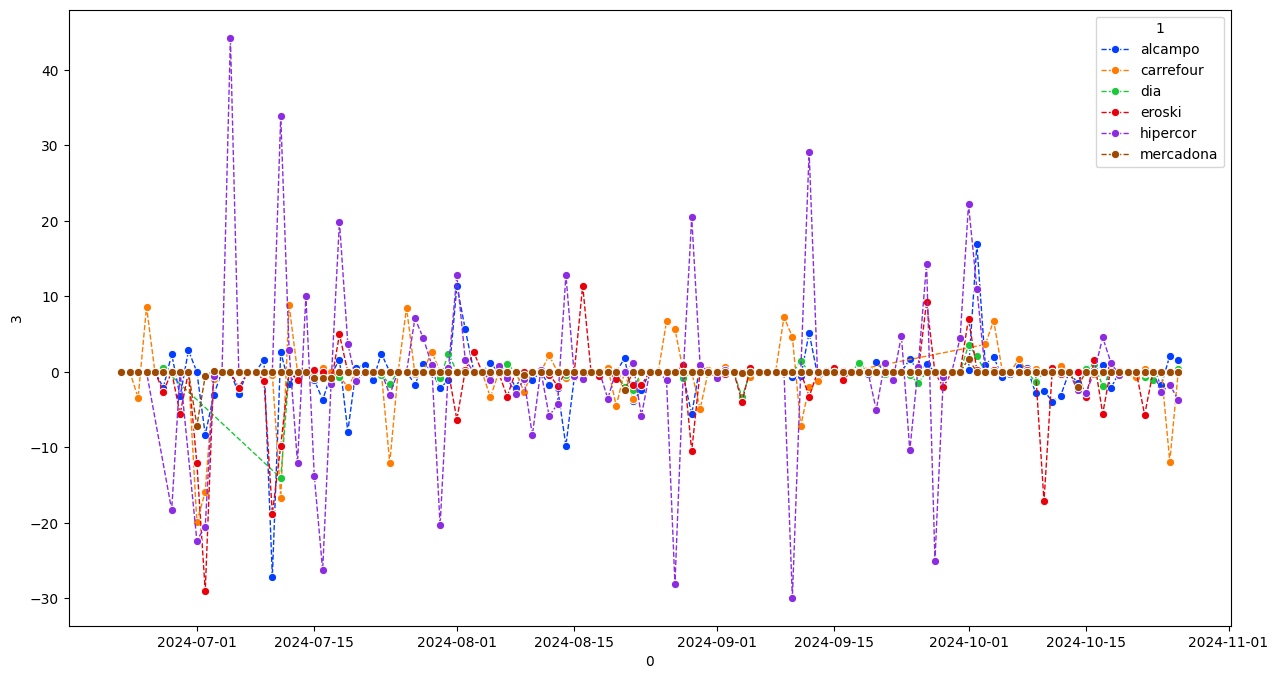

In [65]:
plt.figure(figsize=(15,8))
sns.lineplot(x = dfanomalias_prueba[0],
              y = dfanomalias_prueba[3], 
              hue = dfanomalias_prueba[1], 
               marker = "o", 
                linewidth = 1, 
                palette="bright", 
                linestyle = "dashed", 
                errorbar = None)

Análisis de la Dispersión de Precios: Evaluar la variabilidad de los precios de un mismo producto en diferentes supermercados.

In [11]:
cursor=conexion.cursor()
query_dispersion_precios= """
SELECT c.categoria , s.supermercado, 
avg(dh.precio) AS precio_promedio,
min(dh.precio) AS precio_minimo,
max(dh.precio) AS precio_maximo
FROM datos_historicos dh 
inner JOIN supermercado s 
ON dh.id_supermercado = s.id_supermercado 
INNER JOIN categoria c 
ON dh.id_categoria = c.id_categoria 
GROUP BY c.categoria, s.supermercado 
ORDER BY c.categoria;
"""
cursor.execute(query_dispersion_precios)
df_dispersion_precios= pd.DataFrame(cursor.fetchall())

In [15]:
df_dispersion_precios.head()

,0,1,2,3,4
0,aceite-de-girasol,alcampo,4.131640,1.00,15.88
1,aceite-de-girasol,carrefour,8.183978,1.45,40.67
2,aceite-de-girasol,dia,5.100328,1.49,10.99
3,aceite-de-girasol,eroski,3.522112,1.39,11.99
4,aceite-de-girasol,hipercor,3.613664,1.40,12.79


Comparación de Precios Promedio: Calcular y comparar los precios promedio de cada producto en diferentes supermercados.

In [12]:
cursor=conexion.cursor()
query_comparar_precios = """
SELECT round(CAST (avg(precio) AS NUMERIC), 2) AS precio_pomedio, s.supermercado , c.categoria 
FROM datos_historicos dh 
inner JOIN supermercado s 
ON dh.id_supermercado = s.id_supermercado 
INNER JOIN categoria c 
ON dh.id_categoria = c.id_categoria 
GROUP BY s.supermercado , c.categoria 
ORDER BY c.categoria;
"""
cursor.execute(query_comparar_precios)
df_comparacion_precios = pd.DataFrame(cursor.fetchall())

In [16]:
df_comparacion_precios.head()

,0,1,2
0,4.13,alcampo,aceite-de-girasol
1,8.18,carrefour,aceite-de-girasol
2,5.10,dia,aceite-de-girasol
3,3.52,eroski,aceite-de-girasol
4,3.61,hipercor,aceite-de-girasol
